##Step 1: Setup Your Jupyter Notebook install libaries
Make sure all necessary libraries are installed:

In [125]:
#pip install windrose

Note: you may need to restart the kernel to use updated packages.


In [1]:
import rasterio
import numpy as np
import cv2
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, uniform_filter, sobel, prewitt
from skimage.filters import roberts
from scipy.ndimage import convolve
from windrose import WindroseAxes

##Step 2: Load DEM

In [2]:
dem_path = 'DEMs/USGS_1M_12_x50y381_AZ_USFS_3DEP_Processing_2019_D20.tif'
with rasterio.open(dem_path) as src:
    dem = src.read(1)
    dem[dem == 0] = np.nan  # Replace 0 with NaN



In [3]:
# set zero values as No Data
min_non_zero = np.nanmin(dem)

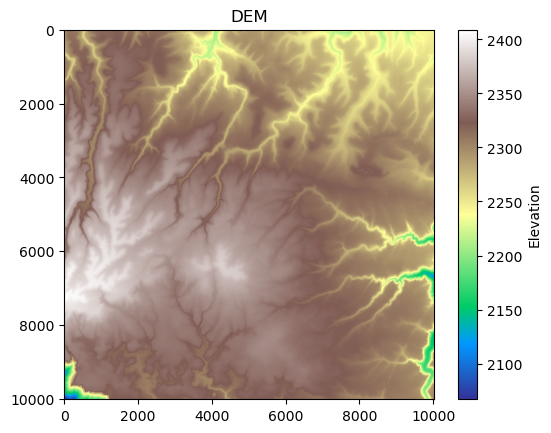

In [4]:
# plot the DEM
plt.imshow(dem, cmap = 'terrain',vmin=min_non_zero)
plt.colorbar(label = 'Elevation')
plt.title('DEM')
plt.show()

##Step 3: Apply Smoothing Filter

In [5]:
# Apply Gaussian smoothing using 1 sigma as the filter level
smoothed_dem = gaussian_filter(dem, sigma = 1)
# mean filter with kernal size of 3
filtered_dem = uniform_filter(dem, size=3)

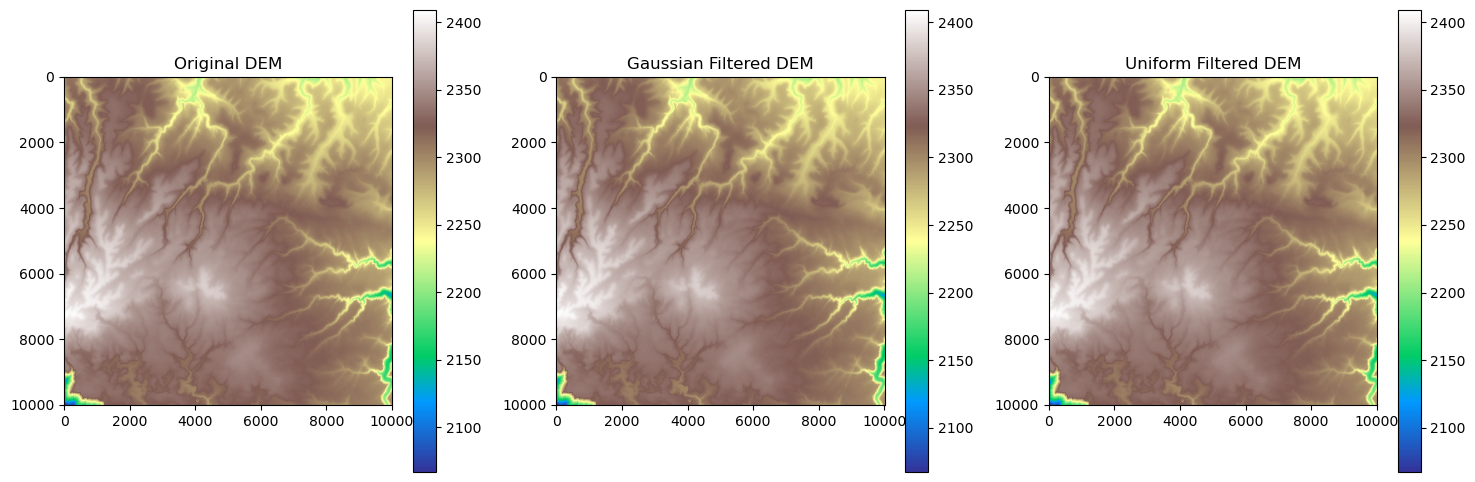

In [6]:
plt.figure(figsize=(18, 6))  # Increase figure size for better visibility

# Plot original DEM
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
plt.imshow(dem, cmap='terrain')
plt.title('Original DEM')
plt.colorbar()

# Plot DEM with Gaussian Filter
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
plt.imshow(smoothed_dem, cmap='terrain')
plt.title('Gaussian Filtered DEM')
plt.colorbar()

# Plot DEM with Uniform Filter
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
plt.imshow(filtered_dem, cmap='terrain')
plt.title('Uniform Filtered DEM')
plt.colorbar()

plt.show()

##Step 4: Apply Directional Filters
You can create custom kernels for directional filtering or use existing filters. 

In [7]:
# create N-S sobel filter

kernel_ns = np.array([
    [ 1, 2, 1],
    [ 0, 0, 0],
    [-1,-2,-1]
])

# create E-W sobel filter
kernel_ew = np.array([
    [ 1, 0, -1],
    [ 2, 0, -2],
    [ 1, 0, -1]
])

## Create NE-SW and SW-NE filters 
# NE-SW Sobel-like kernel
kernel_ne_sw = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

kernel_sw_ne = np.array([
    [ 1, 0, -1],
    [ 2, 0, -2],
    [ 1, 0, -1]
])

# create NE-SW and SW-NE filters:
# Assuming 'dem' is your loaded digital elevation model data
edges_ns = convolve(filtered_dem, kernel_ns)
edges_ew = convolve(smoothed_dem, kernel_ew)
edges_ne_sw = convolve(filtered_dem, kernel_ne_sw)
edges_sw_ne = convolve(smoothed_dem, kernel_sw_ne)

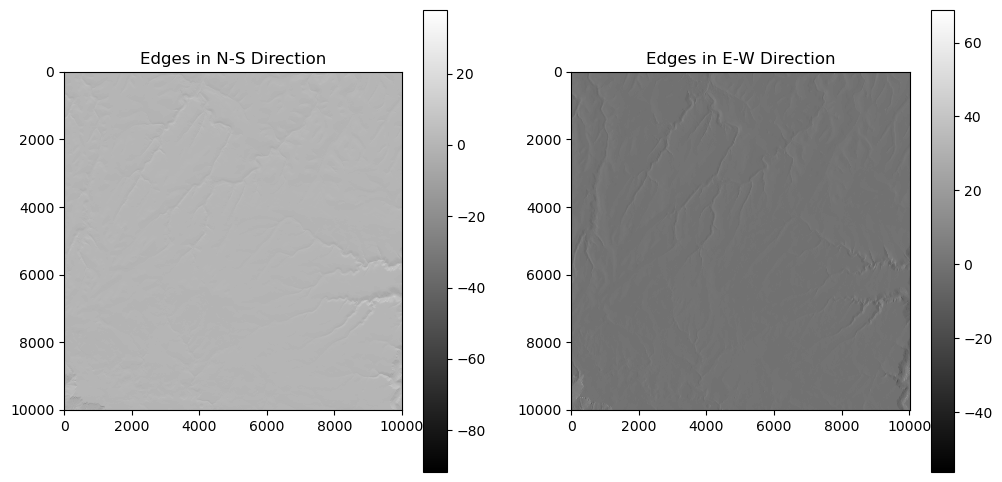

In [8]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(edges_ns, cmap='gray')
plt.title('Edges in N-S Direction')
plt.colorbar()

plt.subplot(122)
plt.imshow(edges_ew, cmap='gray')
plt.title('Edges in E-W Direction')
plt.colorbar()

plt.show()

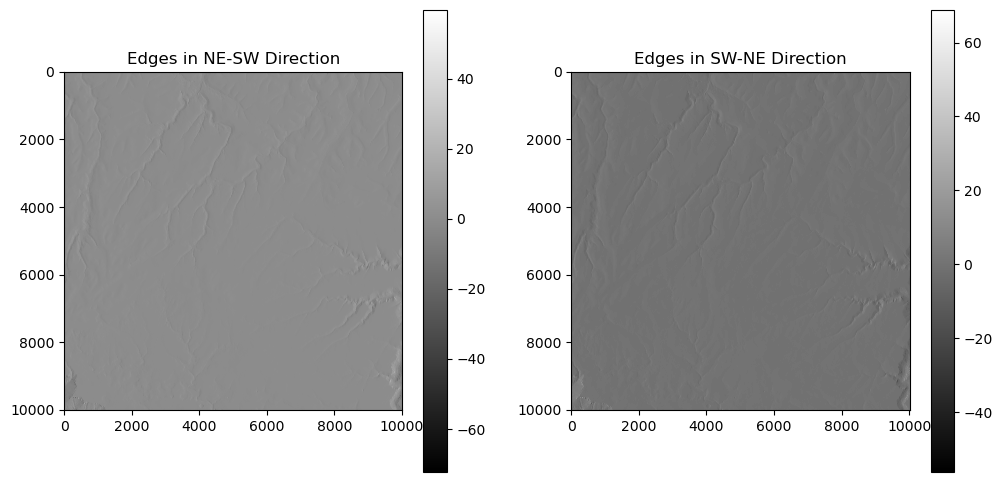

In [9]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(edges_ne_sw, cmap='gray')
plt.title('Edges in NE-SW Direction')
plt.colorbar()

plt.subplot(122)
plt.imshow(edges_sw_ne, cmap='gray')
plt.title('Edges in SW-NE Direction')
plt.colorbar()

plt.show()

In [10]:
sobel_ns = sobel(smoothed_dem, axis=0)  # N-S
sobel_ew = sobel(smoothed_dem, axis=1)  # E-W

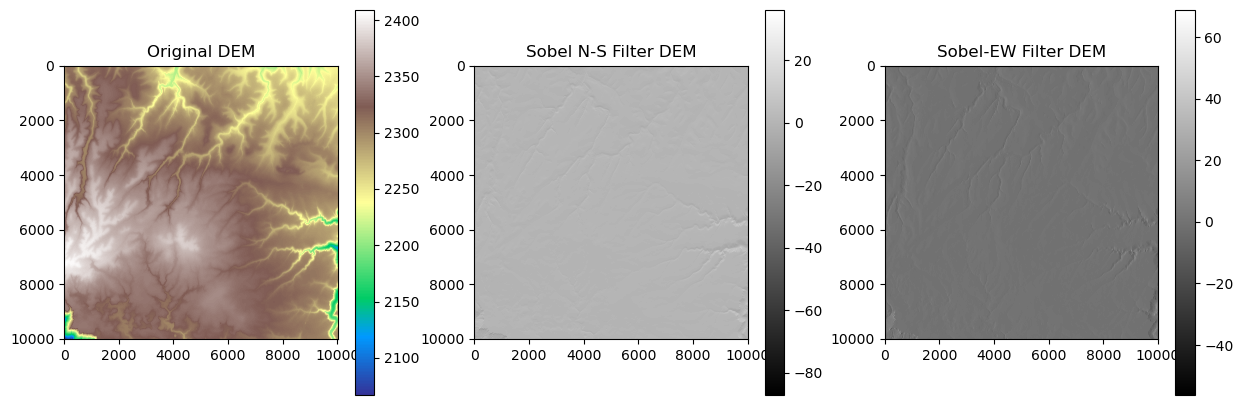

In [11]:
plt.figure(figsize=(15, 5))

# Plot original DEM
plt.subplot(1, 3, 1)
plt.imshow(dem, cmap='terrain')
plt.title('Original DEM')
plt.colorbar()

# Plot DEM after applying Sobel N-S
plt.subplot(1, 3, 2)
plt.imshow(sobel_ns, cmap='gray')
plt.title('Sobel N-S Filter DEM')
plt.colorbar()

# Plot DEM after applying Sobel E-W
plt.subplot(1, 3, 3)
plt.imshow(sobel_ew, cmap='gray')
plt.title('Sobel-EW Filter DEM')
plt.colorbar()

plt.show()

In [12]:
# Apply Prewitt Filter
prewitt_dem = prewitt(smoothed_dem)

# Apply Roberts Cross Filter
roberts_dem = roberts(smoothed_dem)

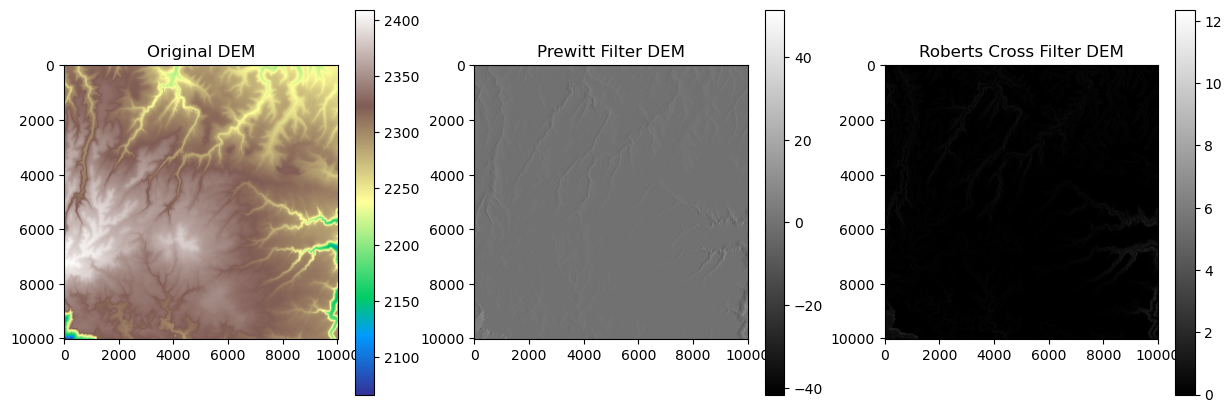

In [13]:
plt.figure(figsize=(15, 5))

# Plot original DEM
plt.subplot(1, 3, 1)
plt.imshow(dem, cmap='terrain')
plt.title('Original DEM')
plt.colorbar()

# Plot DEM after applying Prewitt Filter
plt.subplot(1, 3, 2)
plt.imshow(prewitt_dem, cmap='gray')
plt.title('Prewitt Filter DEM')
plt.colorbar()

# Plot DEM after applying Roberts Cross Filter
plt.subplot(1, 3, 3)
plt.imshow(roberts_dem, cmap='gray')
plt.title('Roberts Cross Filter DEM')
plt.colorbar()

plt.show()

Step 5: Combine Edge Detection
Combine the outputs from the different filters to enhance linear feature detection:

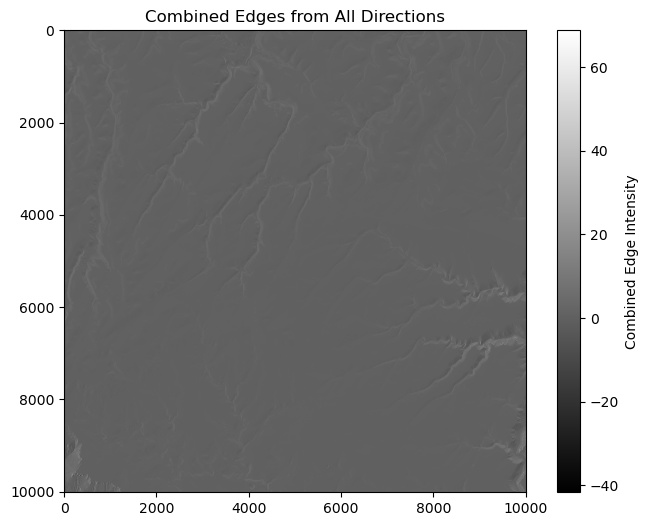

In [22]:
#combined_edges = np.sqrt(sobel_ew**2 + sobel_ns**2 )
combined_edges = np.maximum.reduce([prewitt_dem, sobel_ew, sobel_ns])
plt.figure(figsize=(8, 6))
plt.imshow(combined_edges, cmap='grey')
plt.colorbar(label='Combined Edge Intensity')
plt.title('Combined Edges from All Directions')
plt.show()

In [23]:
# Apply a threshold
mean_val = np.mean(combined_edges)
std_val = np.std(combined_edges)
thresh_val = mean_val + std_val  # You can adjust this thresholding logic

# create binary edges on the detected lines
_, binary_edges = cv2.threshold(combined_edges.astype(np.float32), thresh_val, 255, cv2.THRESH_BINARY)
binary_edges = binary_edges.astype(np.uint8)

# thin the edges
thinned_edges = cv2.ximgproc.thinning(binary_edges)

# prune curves
min_length_threshold = 10
contours, _ = cv2.findContours(thinned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
pruned_contours = [cnt for cnt in contours if cv2.arcLength(cnt, closed=False) > min_length_threshold]

# recursive Curve Segmentation
from skimage.measure import approximate_polygon

segmented_lines = [approximate_polygon(cnt.squeeze(), tolerance=2.0) for cnt in pruned_contours]


AttributeError: module 'cv2' has no attribute 'ximgproc'

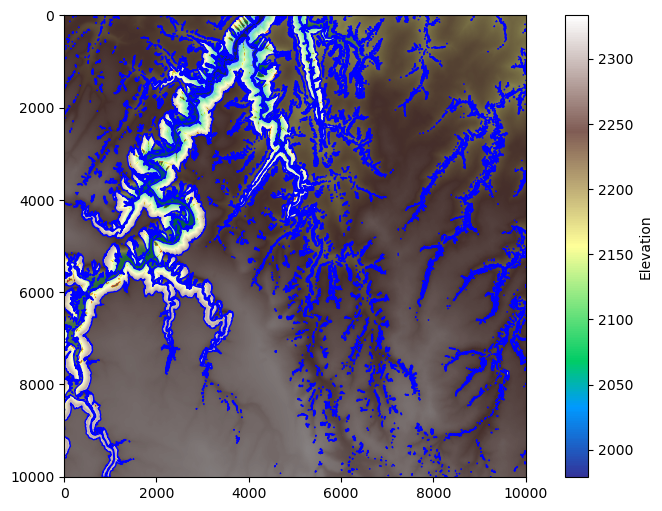

In [108]:
plt.figure(figsize=(10, 6))
plt.imshow(dem, cmap='terrain')  # Use a colormap that represents elevation well, such as 'terrain'
plt.colorbar(label='Elevation')
plt.imshow(binary_edges, cmap='hot', alpha=0.5)  # Semi-transparent overlay of binary edges
# Using matplotlib to manually draw contours
for contour in contours:
    # Reshape and plot each contour
    x, y = contour[:, 0, 0], contour[:, 0, 1]
    plt.plot(x, y, color='blue', linewidth=1) 
plt.show()

In [120]:
with rasterio.open(dem_path) as src:
    transform = src.transform

# Assuming 'contours' are derived from this DEM
line_geometries = []
for contour in contours:
    if len(contour) > 3:  # Ensure meaningful size
        # Transform each contour point from pixel coordinates to spatial coordinates
        spatial_contour = [transform * point for point in contour[:, 0, :]]
        line = LineString(spatial_contour)
        line_geometries.append(line)



In [124]:
# Create a GeoDataFrame and export the shapefile 
#gdf_lines = gpd.GeoDataFrame(geometry=line_geometries)
##gdf_lines['Azimuth'] = gdf_lines['geometry'].apply(calculate_azimuth)
#gdf_lines['Azimuth'] = gdf_lines['geometry'].apply(calculate_azimuth).astype(float)
#gdf_lines.crs = "EPSG:32612"  # Set the correct CRS for UTM Zone 12N
#gdf_lines.to_file("DEMs/output/detected_lineaments.shp")


gdf = gpd.GeoDataFrame(geometry=[LineString(seg) for seg in segmented_lines])
gdf['linked'] = False  # To track already linked lines
linked_lines = []
for index, line in gdf.iterrows():
    if not line['linked']:
        # Find nearby lines and check alignment
        potential_matches = gdf[gdf.distance(line.geometry) < proximity_threshold]
        for _, match in potential_matches.iterrows():
            if aligns_well(line.geometry, match.geometry):
                # Merge lines and mark as linked
                merged_line = merge_lines(line.geometry, match.geometry)
                linked_lines.append(merged_line)
                gdf.at[index, 'linked'] = True
                gdf.at[match.name, 'linked'] = True

with rasterio.open(dem_path) as src:
    dem = src.read(1)  # Read the first band
    transform = src.transform

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(dem, cmap='gray', extent=rasterio.plot.plotting_extent(src))
    linked_lines.plot(ax=ax, color='red', linewidth=1)  # linked_lines is your GeoDataFrame
    plt.show()



C:\Users\rylim\anaconda3\envs\DEM_processing\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [122]:
# function to calculate the azimuth for each line
def calculate_azimuth(line):
    if isinstance(line, LineString) and len(line.coords) > 1:
        start, end = np.array(line.coords[0]), np.array(line.coords[-1])
        azimuth = np.arctan2(end[0] - start[0], end[1] - start[1])
        return np.degrees(azimuth) % 360
    return None

# Apply this function to each line in the GeoDataFrame
linked_lines['Azimuth'] = linked_lines['geometry'].apply(calculate_azimuth)


## Plot the Rose Diagram for Lineaments

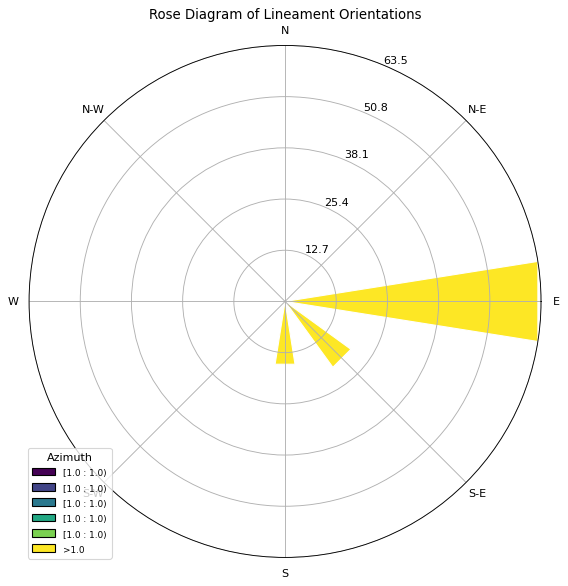

In [128]:
def plot_windrose(azimuths):
    # Create a windrose axes
    ax = WindroseAxes.from_ax()
    # Since we only have azimuth data, we use a placeholder variable, like an array of ones
    # This simulates having one count for each azimuth direction
    frequencies = np.ones_like(azimuths)
    # Plotting the rose diagram
    ax.bar(azimuths, frequencies, normed=True, opening=0.8, edgecolor='white')
    ax.set_legend(title='Azimuth')
    plt.title('Rose Diagram of Lineament Orientations')
    plt.show()

# Example usage
plot_windrose(gdf_lines['Azimuth'].dropna().values)

In [ ]:
# Ensure the output directory exists
output_dir = 'DEMs/output'
os.makedirs(output_dir, exist_ok=True)

# Set the correct CRS
linked_lines.crs = "EPSG:32612"

# Export to Shapefile
shapefile_path = os.path.join(output_dir, 'detected_lineaments.shp')
linked_lines.to_file(shapefile_path)